# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta
import os

In [2]:
from my_functions import exploiting_words, cleaning_shop_categs, indexing_shop_categs, convert_bronze, merge_basic, supagg
from my_functions import reduce_sample, get_val_window
from my_functions import preparing_to_predict, plot_metrics
from my_functions import My_ML_prediction_on_test, scaler, consolidated_metrics_MSE, consolidated_plot_metrics
from my_functions import get_splited_data, plot_prediction, inversed_scale, consolidation_prediction

In [3]:
from especial_functions import balance_items_test, get_full_lags, feature_silver, integration_new_features_map
from especial_functions import features_rows_train_silver, get_maps_from, balance_items_test, augmentation_reduction

In [4]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [5]:
import warnings
warnings.filterwarnings('ignore')

## The Data

### References

In [6]:
to_drop_columns = ['Date']
ids_columns = ['item_category_id', 'item_id','shop_id',
              'shop_id_term_5','shop_id_term_10', 'map1_shop_term_5',
               'map1_shop_term_10','map2_shop_term_5', 'map2_shop_term_10'] #
strings_number = ['lenstr', 'NWords', 'ItemWord0', 'ItemWord_1', 'map_categ_comp1', 'map_categ_comp2',
                 'map_shop_comp1', 'map_shop_comp2']
numericals = [ 'OrderGot', 'SpaceOrder', 'Explosition_item', 'L1_Explosition_item',
       'count_unique_item', 'count_unique_shop_id',
       'count_unique_shop_itemword', 'count_unique_itemword_shop', 'L1_Item',
       'L2_Item','L1_Shop', 'L2_Shop', 'L3_Shop',
       'L1_ItemWord0', 'L2_ItemWord0', 'L1_ItemWord_1', 'L2_ItemWord_1',
       'L1_shopcomp', 'L2_shopcomp', 'L1_shop_comp1', 'L2_shop_comp1',
       'L1_ShopItemWord', 'L2_ShopItemWord', 'L3_ShopItemWord',
       'L1_noNull_ShopItemWord', 'L2_noNull_ShopItemWord',
       'L3_noNull_ShopItemWord', 'L1_ShopCompItemWord', 'L2_ShopCompItemWord',
       'L3_ShopCompItemWord', 'L1_ShopCompItem', 'L2_ShopCompItem',
       'L3_ShopCompItem', 'L1_ceros_positives_item_id',
       'L2_ceros_positives_item_id', 'L1_ceros_positives_shop_id',
       'L2_ceros_positives_shop_id', 'L1_ceros_positives_ItemWord0',
       'L2_ceros_positives_ItemWord0', 'L1_ceros_positives_shop_itemword',
       'L2_ceros_positives_shop_itemword', 'L1_ceros_Ceros_item_id',
       'L2_ceros_Ceros_item_id', 'L1_ceros_Ceros_shop_id',
       'L2_ceros_Ceros_shop_id', 'L1_ceros_Ceros_ItemWord0',
       'L2_ceros_Ceros_ItemWord0', 'L1_ceros_Ceros_shop_ItemWord0',
       'L2_ceros_Ceros_shop_ItemWord0', 'item_id_mean_LastOrder',
       'shop_id_mean_LastOrder', 'map_shop_comp1_mean_LastOrder',
       'shop_id_ItemWord0_mean_LastOrder',
       'map_shop_comp1_item_id_mean_LastOrder', 'ItemId_meanL1Price',
       'shopid_meanL1Price', 'ItemWord0_meanL1Price',
       'shopid_itemWord0_meanL1Price'] + ids_columns + strings_number

categoricals = ['SpaceOrderActivator', 'CategoryL1Item']
my_features = to_drop_columns + numericals + categoricals
my_target = 'Sale'
len(my_features) - 3

75

In [7]:
my_columns_to_drops = ['Explosition_item', 'CategoryL1Item_A','item_category_id','SpaceOrder','lenstr', 
                       'map_shopid_meanL1Price', 'item_id_mean_LastOrder','L1_Explosition_item'] + \
    ['CategoryL1Item_0','CategoryL1Item_B','SpaceOrderActivator_A', 'SpaceOrderActivator_B', 'CategoryL1Item_D','CategoryL1Item_C','CategoryL1Item_0',]

In [8]:
feature_dictionary = {'numericals':numericals,
                     'categoricals': categoricals,
                     'my_target':my_target,
                      'features_to_drop': my_columns_to_drops}

In [9]:
zero_vector = [0.60, 0.01, 0.01, 0.8]

In [10]:
def my_kfold_crossval_and_Hptunning(data_dict, models_toTrain, features_dict, zero_vector ,frac = 1.0):

    results = {'machine label': list(),
        'machine result': list()}

    for machine,i in zip(models_toTrain, range(1,len(models_toTrain) + 1)):
        label = f'machine-{i}'
        results['machine label'].append(label)
        df_result = My_ML_prediction_on_test( data_dict = data_dict, dates_vector = test_dates, model = machine, zero_vector = zero_vector,
                                             features_dict = features_dict, frac = frac)
        results['machine result'].append(df_result)
        print(label + ' is done')
        
    return results

In [11]:
def consolidated_plot_metrics(data):
    list_dfplot = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        df_plot = plot_metrics(result_detail)
        df_plot['machine'] = label
        list_dfplot.append(df_plot)
    
    return pd.concat(list_dfplot)

In [12]:
def consolidated_metrics_MSE(data):
    labels = list()
    RMSEs = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        pred = result_detail['Sale']
        real = result_detail['PredSale']
        rmse = mean_squared_error(real,pred)**(1/2)
        labels.append(label)
        RMSEs.append(rmse)
    
    return pd.DataFrame({'machine':labels,'RMSE': RMSEs}).sort_values('RMSE')

### Data

In [13]:
test_dates = [datetime.datetime(2014, 10, 1), datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [14]:
dictionary_data = get_splited_data(dates_vector = test_dates)

2014-10-01
2014-11-01
2015-04-01
2015-05-01
2015-06-01
2015-07-01
2015-08-01
2015-09-01
2015-10-01


In [15]:
for key in dictionary_data['Train Data'].keys():
    print(len(dictionary_data['Train Data'][key]))

944294
968096
1096202
1107834
1119007
1129758
1139922
1173448
1204728


### Ada Boost machine

In [17]:
my_adab_models = list()
number_of_machines = 15
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [40,50, 50, 30, 30, 45, 60, 40, 50, 35, 15, 25, 25, 30, 18,],
    'min_samples_split':[10, 4, 10, 7, 9, 15, 3, 3, 5, 5, 10, 7, 4, 9, 15,],
    'min_samples_leaf':[10, 7, 12, 5, 10, 5, 15, 3, 15, 12, 15, 5, 5, 15, 10],
    'max_features':[15, 23, 23, 20, 15, 21, 18, 15, 20, 18, 25, 10, 10, 20, 25],
              
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60, 50, 20, 40, 40, 35],
    'learning_rate' : [0.05, 0.08, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005, 0.001, 0.09, 0.004, 0.0001, 0.009] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = max_depth_param, min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param , max_features = max_features_param)
    my_adab = AdaBoostRegressor(base_estimator = my_base, n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='linear')
    my_adab_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [18]:
%%time
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_adab_models[0]], zero_vector = zero_vector,
                                                  features_dict = feature_dictionary, frac = 0.05)

machine-1 is done
Wall time: 4min


In [19]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

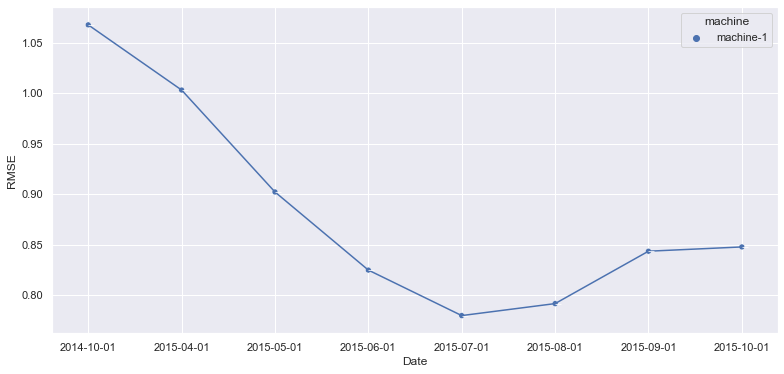

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot[metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot[metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", s = 35, hue= 'machine' )

In [21]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
0,machine-1,1.135561


<b> multiple experimets

In [22]:
list_metrics_toplot = list()
for i in range(1,11):
    my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_adab_models[0]], zero_vector = zero_vector,
                                                  features_dict = feature_dictionary, frac = 0.01)
    metrics_toplot = consolidated_plot_metrics(my_test_results)
    metrics_toplot['Sample'] = f'Sample-{i}'
    list_metrics_toplot.append(metrics_toplot)
list_metrics_toplot = pd.concat(list_metrics_toplot)

machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done


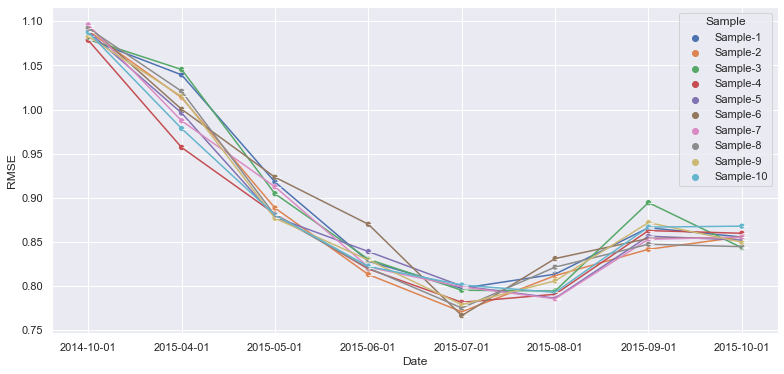

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", marker = True, hue = 'Sample', legend = False )
ax = sns.scatterplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", s = 35, hue= 'Sample' )

In [24]:
list_metrics_toplot[metrics_toplot.Date != '2014-11-01'].RMSE.mean()

0.8901382012140047

#### Kfold cross validation and hyper parameter tunning

In [25]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  my_adab_models, frac = 0.005, zero_vector = zero_vector,
                                                 features_dict = feature_dictionary)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done
machine-11 is done
machine-12 is done
machine-13 is done
machine-14 is done
machine-15 is done


In [26]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

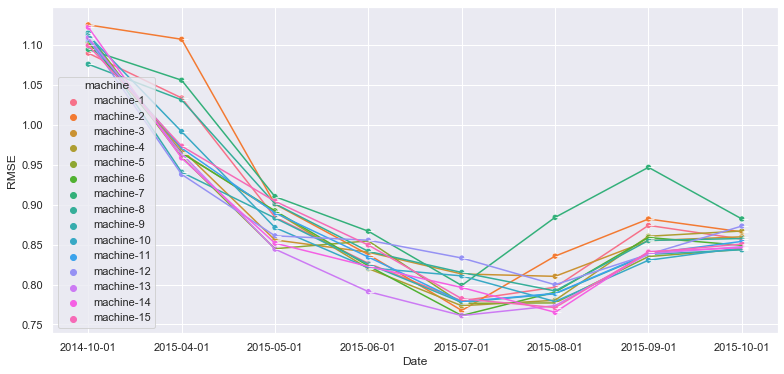

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot[metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot[metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", s = 35, hue= 'machine' )

In [28]:
def consolidated_metrics_MSE_filtered(data,dates):
    labels = list()
    RMSEs = list()
    for i in range(len(data['machine label'])):
        label = data['machine label'][i]
        result_detail = data['machine result'][i]
        result_detail = result_detail[~result_detail.Date.isin(dates)]
        pred = result_detail['Sale']
        real = result_detail['PredSale']
        rmse = mean_squared_error(real,pred)**(1/2)
        labels.append(label)
        RMSEs.append(rmse)
    
    return pd.DataFrame({'machine':labels,'RMSE': RMSEs}).sort_values('RMSE')

In [29]:
consolidated_metrics_MSE_filtered(my_test_results, ['2014-11-01'])

,machine,RMSE
12,machine-13,0.869281
4,machine-5,0.878182
13,machine-14,0.878195
8,machine-9,0.878742
5,machine-6,0.882978
10,machine-11,0.884952
9,machine-10,0.885275
3,machine-4,0.885812
14,machine-15,0.886153
11,machine-12,0.889647


#### Winner Prediction

Machine 5 is the winner 0.857415 rmse

In [47]:
list_metrics_toplot = list()
for i in range(1,11):
    my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_adab_models[4]], zero_vector = zero_vector,
                                                  features_dict = feature_dictionary, frac = 0.05)
    metrics_toplot = consolidated_plot_metrics(my_test_results)
    metrics_toplot['Sample'] = f'Sample-{i}'
    list_metrics_toplot.append(metrics_toplot)
list_metrics_toplot = pd.concat(list_metrics_toplot)

machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done


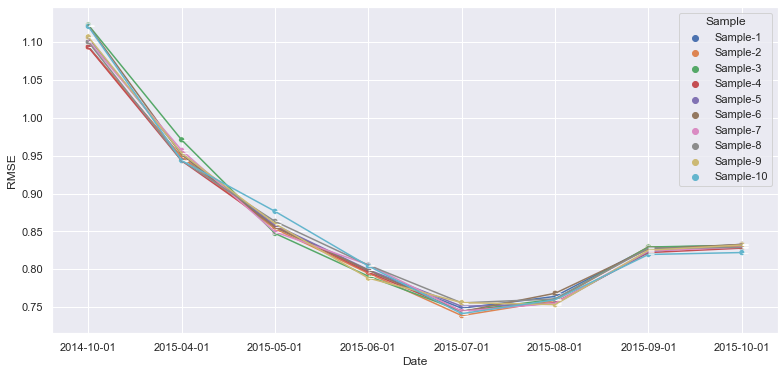

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", marker = True, hue = 'Sample', legend = False )
ax = sns.scatterplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", s = 35, hue= 'Sample' )

In [53]:
list_metrics_toplot[metrics_toplot.Date != '2014-11-01'].RMSE.mean()

0.8594625880731328

### Saving prediction for stacking

In [52]:
my_test_results['machine result'][0].to_csv('preds_stacking/preds_adaboost.csv',header = True, index = False)

### Gradient Boosting

In [17]:
my_gbr_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [40,30, 20, 35, 35, 30, 25, 25, 30, 40],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12],
    'max_features':[25, 22, 25, 25, 28, 19, 23, 22, 25, 20],
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60],
    'learning_rate' : [0.05, 0.12, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_adab = GradientBoostingRegressor( n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='squared_error',
                                       max_depth = max_depth_param, min_samples_split = min_samples_split_param , max_features = max_features_param,
                                       min_samples_leaf = min_samples_leaf_param)
    my_gbr_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [59]:
%%time
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_gbr_models[0]], zero_vector = zero_vector,
                                                  features_dict = feature_dictionary, frac = 0.05)

machine-1 is done
Wall time: 3min 31s


In [60]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

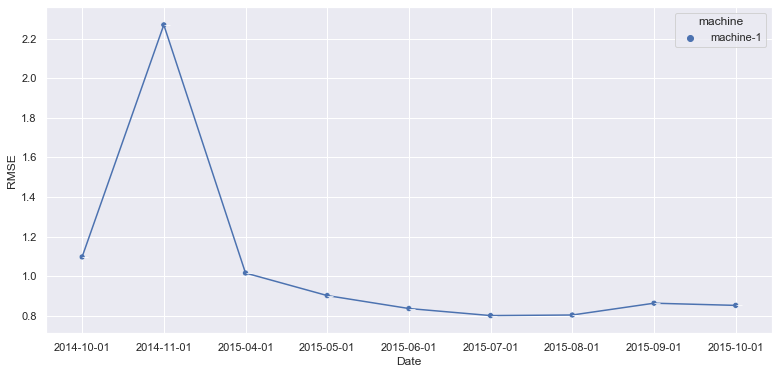

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [62]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
0,machine-1,1.1219


<b> multiple experimets

In [63]:
list_metrics_toplot = list()
for i in range(1,11):
    my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_gbr_models[0]], zero_vector = zero_vector,
                                                  features_dict = feature_dictionary, frac = 0.05)
    metrics_toplot = consolidated_plot_metrics(my_test_results)
    metrics_toplot['Sample'] = f'Sample-{i}'
    list_metrics_toplot.append(metrics_toplot)
list_metrics_toplot = pd.concat(list_metrics_toplot)

machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done


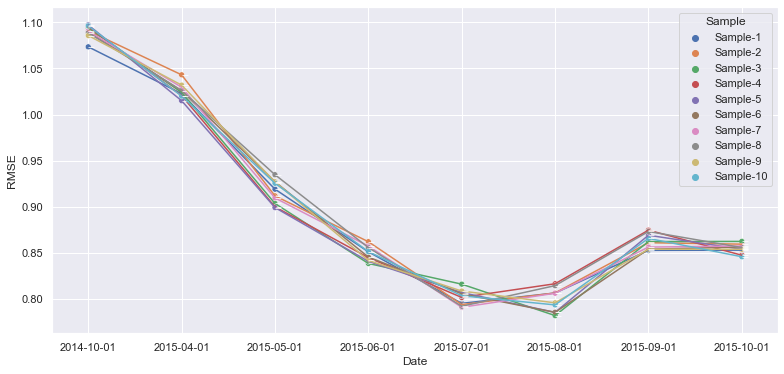

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", marker = True, hue = 'Sample', legend = False )
ax = sns.scatterplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", s = 35, hue= 'Sample' )

In [65]:
list_metrics_toplot[metrics_toplot.Date != '2014-11-01'].RMSE.mean()

0.8996168276948764

### Kfold cross validation and hyper parameter tunning

In [20]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  my_gbr_models, zero_vector = zero_vector,
                                                  features_dict = feature_dictionary, frac = 0.01)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [24]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

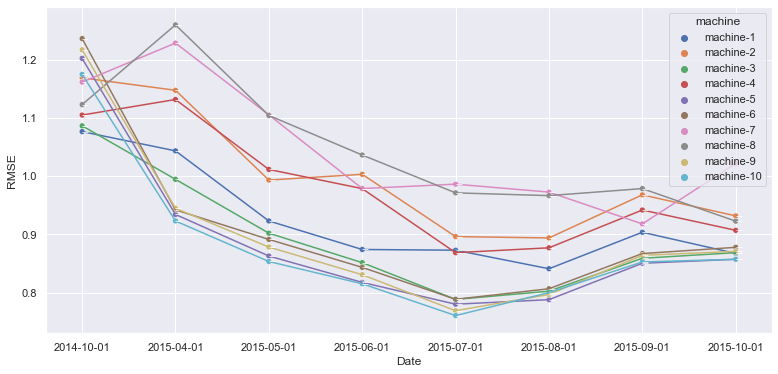

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot[metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot[metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", s = 35, hue= 'machine' )

In [26]:
consolidated_metrics_MSE_filtered(my_test_results, ['2014-11-01'])

,machine,RMSE
9,machine-10,0.883403
4,machine-5,0.890911
2,machine-3,0.895940
8,machine-9,0.901085
5,machine-6,0.911250
0,machine-1,0.926195
3,machine-4,0.979418
1,machine-2,1.002040
7,machine-8,1.048012
6,machine-7,1.048790


### Winner Prediction

machine 10 is winner - 0.883403 RMSE

In [28]:
list_metrics_toplot = list()
for i in range(1,11):
    my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_gbr_models[9]], zero_vector = zero_vector,
                                                  features_dict = feature_dictionary, frac = 0.01)
    metrics_toplot = consolidated_plot_metrics(my_test_results)
    metrics_toplot['Sample'] = f'Sample-{i}'
    list_metrics_toplot.append(metrics_toplot)
list_metrics_toplot = pd.concat(list_metrics_toplot)

machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done
machine-1 is done


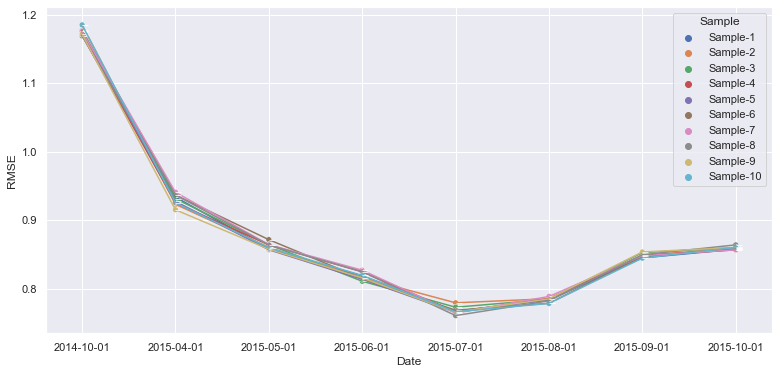

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", marker = True, hue = 'Sample', legend = False )
ax = sns.scatterplot(ax = axs , data = list_metrics_toplot[metrics_toplot.Date != '2014-11-01'][metrics_toplot.Date != '2014-11-01'], x="Date", y="RMSE", s = 35, hue= 'Sample' )

In [30]:
list_metrics_toplot[metrics_toplot.Date != '2014-11-01'].RMSE.mean()

0.8803745410044458

### Saving Results for Stacking

In [31]:
my_test_results['machine result'][0].to_csv('preds_stacking/preds_gradboost.csv',header = True, index = False)

----

### Random Forest

In [22]:
my_rf_models = list()
number_of_machines = 10
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [40,30, 20, 35, 35, 30, 25, 25, 30, 40],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12],
    'max_features':[25, 22, 25, 25, 10, 19, 23, 22, 25, 20],
    'n_estimators' : [300, 250, 150, 150, 250, 335, 250, 120, 285, 360]}

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    n_estimators_param = parameters['n_estimators'][i]
    
    my_rf = GradientBoostingRegressor( n_estimators = n_estimators_param, max_depth = max_depth_param, min_samples_split = min_samples_split_param ,
                                      max_features = max_features_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [23]:
%%time
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  [my_rf_models[0]], frac = 0.05)

machine-1 is done
Wall time: 16min 8s


In [24]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

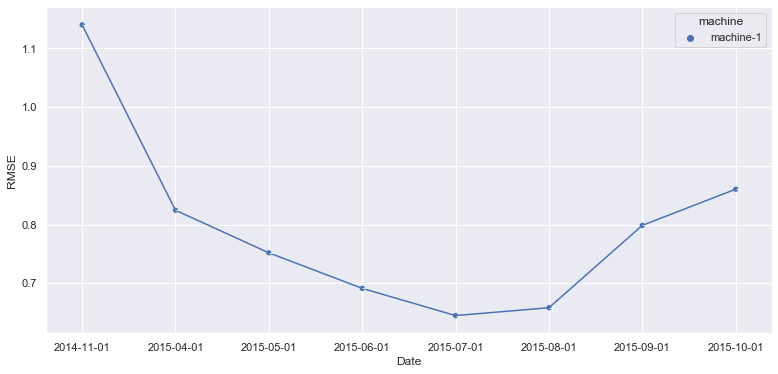

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [26]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
0,machine-1,0.810099


### Kfold cross validation and hyper parameter tunning

In [27]:
my_test_results = my_kfold_crossval_and_Hptunning(data_dict = dictionary_data, models_toTrain =  my_rf_models, frac = 0.005)

machine-1 is done
machine-2 is done
machine-3 is done
machine-4 is done
machine-5 is done
machine-6 is done
machine-7 is done
machine-8 is done
machine-9 is done
machine-10 is done


In [28]:
metrics_toplot = consolidated_plot_metrics(my_test_results)

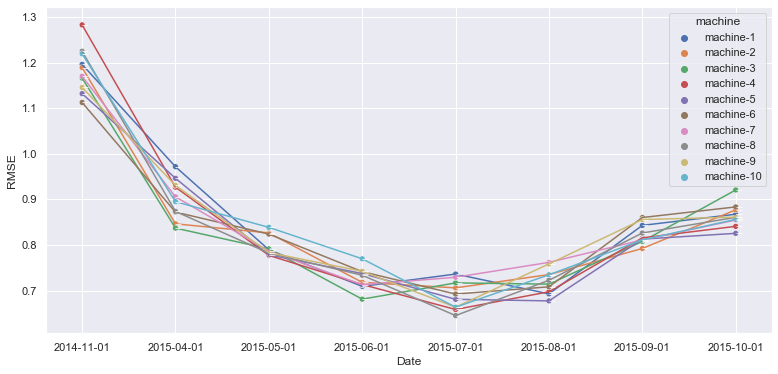

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(13,6), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )

In [30]:
consolidated_metrics_MSE(my_test_results)

,machine,RMSE
4,machine-5,0.836028
2,machine-3,0.842268
5,machine-6,0.846253
1,machine-2,0.848914
7,machine-8,0.849712
6,machine-7,0.852737
8,machine-9,0.853876
3,machine-4,0.859516
9,machine-10,0.862783
0,machine-1,0.865039


Random Forest is not an option

---

### Stacking

In [32]:
preds_gradBoost = pd.read_csv('preds_stacking/preds_gradboost.csv').rename(columns = {'PredSale':'PredSale_gradBoost'})
preds_adaBoost = pd.read_csv('preds_stacking/preds_adaboost.csv').rename(columns = {'PredSale':'PredSale_adaBoost'})

In [33]:
columns_1 = ['Date','shop_id','item_id','PredSale_gradBoost','Sale']
columns_2 = ['PredSale_adaBoost']

In [34]:
merge_preds = preds_gradBoost[columns_1].merge(preds_adaBoost[columns_2], left_index=True, right_index=True, how = 'left')
merge_preds['Date'] = pd.to_datetime(merge_preds.Date)
merge_preds['month'] = merge_preds.Date.dt.month

##### Train stacking data

In [35]:
my_features_stack = ['PredSale_gradBoost','PredSale_adaBoost','item_id', 'shop_id']
my_target = 'Sale'

In [36]:
merge_preds.head()

,Date,shop_id,item_id,PredSale_gradBoost,Sale,PredSale_adaBoost,month
0,2014-10-01,54,0,0.461584,0.0,0.000000,10
1,2014-10-01,55,1,0.821328,1.0,1.062500,10
2,2014-10-01,54,2,0.773751,0.0,1.166667,10
3,2014-10-01,54,3,0.884549,0.0,1.176471,10
4,2014-10-01,54,4,0.461585,0.0,0.000000,10


In [37]:
merge_preds.PredSale_adaBoost.max(), merge_preds.Sale.max(), merge_preds.PredSale_gradBoost.max()

(8.999999999999998, 20.0, 1.9860813307640448)

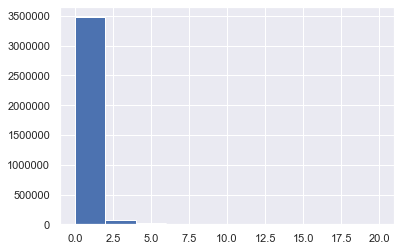

In [38]:
merge_preds.Sale.hist()

In [39]:
def augmentation_reduction_stack(data):
    data_wow = data.copy()
    data_wow = data_wow.reset_index(drop = True)
    zeros = np.array(data_wow[data_wow.Sale == 0].index)
    nx = int(round(zeros.shape[0]*0.80, 0))
    indexes = np.random.choice(zeros.shape[0], nx, replace=False)
    zeros_selected = zeros[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(zeros_selected)]
    
    ones = np.array(data_wow[data_wow.Sale == 1].index)
    nx = int(round(ones.shape[0]*0.8, 0))
    indexes = np.random.choice(ones.shape[0], nx, replace=False)
    ones_selected = ones[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(ones_selected)]
    
    twoes = np.array(data_wow[data_wow.Sale == 2].index)
    nx = int(round(twoes.shape[0]*0.2, 0))
    indexes = np.random.choice(twoes.shape[0], nx, replace=False)
    twoes_selected = twoes[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twoes_selected)]
    
    twenties = np.array(data_wow[data_wow.Sale == 20].index)
    nx = int(round(twenties.shape[0]*0.5, 0))
    indexes = np.random.choice(twenties.shape[0], nx, replace=False)
    twenties_selected = twenties[indexes]
    data_wow = data_wow[ ~data_wow.index.isin(twenties_selected)]
    
    #data_augmented_tens = data_wow[data_wow.Sale > 10].copy()
    data_augmented = pd.concat([data_wow, 
                               ],axis= 0).reset_index()
    
    return data_augmented

In [40]:
merge_preds_augmented = augmentation_reduction_stack(merge_preds)

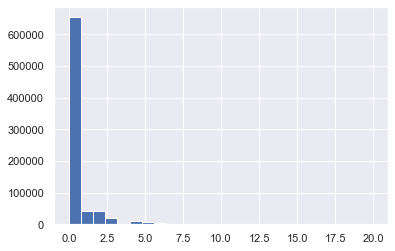

In [41]:
merge_preds_augmented.Sale.hist(bins = 25)

In [42]:
merge_preds_augmented.shape

(787454, 8)

In [43]:
data_to_use = merge_preds[my_features_stack + [my_target] ].copy()

val_index = list(data_to_use[data_to_use.Sale == 0].sample(frac = 0.05).index) + list(data_to_use[data_to_use.Sale != 0].sample(frac = 0.35).index)
val_data = data_to_use[data_to_use.index.isin(val_index)]

train_data = data_to_use[~data_to_use.index.isin(val_index)]
train_index = list(train_data[train_data.Sale == 0].sample(frac = 0.01).index) + list(train_data[train_data.Sale != 0].sample(frac = 0.85).index)
train_data = train_data[train_data.index.isin(train_index)]

In [44]:
X_train = train_data[my_features_stack]
Y_train = train_data[my_target]

X_val = val_data[my_features_stack].copy()

In [45]:
stacker = GradientBoostingRegressor( max_depth = 15,n_estimators = 40, learning_rate = 0.0015, loss='squared_error', )
stacker.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.0015, max_depth=15, n_estimators=40)

In [46]:
Y_pred = stacker.predict(X_val)

In [47]:
val_data_v2 = val_data.copy()
val_data_v2['PredSale'] = Y_pred

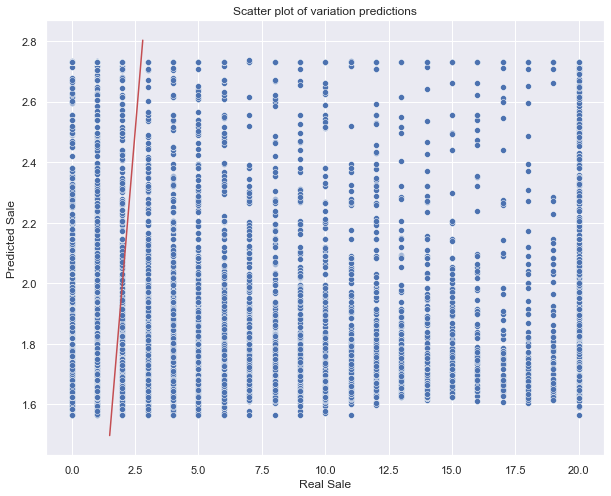

In [50]:
plot_prediction(val_data_v2)

In [51]:
mean_squared_error(val_data_v2['Sale'], val_data_v2['PredSale'])**(1/2) # 0.5152457526534849

2.0028059588504603

----

## Final Prediction

### Data

In [54]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [75]:
date_val = datetime.datetime(2015,11,1)

In [55]:
items_feature =  exploiting_words(data = items)

In [56]:
shops_feature, categories_feature = cleaning_shop_categs(shops, categories)
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp1')
shops_feature = indexing_shop_categs(shops_feature, 'shop_comp2')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp1')
categories_feature = indexing_shop_categs(categories_feature, 'categ_comp2')

In [57]:
### test preparation
test_data = test
test_data['date'] = pd.to_datetime(datetime.datetime(2015, 11, 1))
test_data['date_block_num'] = 35
test_data['item_price'] =  np.nan
test_data['item_cnt_day'] = np.nan
test_data = test_data[daily_train.columns]

In [58]:
train_selection = pd.read_csv(f'generated_datasets/data_2015-11-01/train_selection.csv')

In [59]:
train_augmented = augmentation_reduction(train_selection, fracs = zero_vector)

In [60]:
train_scaled, my_scaler = scaler(train_augmented, numericals, my_target, scaler=None, drop_columns = my_columns_to_drops)
#train_scaled = train_augmented[ numericals + [my_target] ]
if len(categoricals) != 0:
    train_dummies = pd.get_dummies(train_augmented[categoricals])
    train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [61]:
if len(categoricals) != 0:
    final_features = list(train_dummies.columns) +  numericals
else:
    final_features = numericals
final_features = [x for x in final_features if x not in my_columns_to_drops]

In [62]:
train_scaled.shape

(543202, 51)

In [64]:
sample_frac = 0.40
train_scaled_sampled = train_scaled.sample(frac = sample_frac)

In [65]:
train_scaled_sampled.shape

(217281, 51)

### ML Training

In [66]:
X_train = train_scaled_sampled[final_features]
Y_train = train_scaled_sampled[my_target]

In [70]:
%%time
my_ABM = my_adab_models[4]
my_ABM.fit(X_train, Y_train)

Wall time: 1min 8s


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=30,
                                                       max_features=15,
                                                       min_samples_leaf=10,
                                                       min_samples_split=9),
                  learning_rate=0.004)

In [71]:
%%time
my_adab = my_gbr_models[9]
my_adab.fit(X_train, Y_train)

Wall time: 1min 42s


GradientBoostingRegressor(learning_rate=0.005, max_depth=40, max_features=20,
                          min_samples_leaf=12, min_samples_split=5,
                          n_estimators=60)

<b> prepare test to predict

In [72]:
test_bronze = convert_bronze(data = test_data, train = False)
test_merged = merge_basic(train_data = test_bronze, items = items, items_feature = items_feature['item_name_explo'],
                            categories = categories_feature, shops = shops_feature)

In [73]:
test_merged.shape, test.shape

((214200, 21), (214200, 7))

In [76]:
valandtrain_feature_firt = feature_silver(test_merged, date_to_take = date_val, Train = False)

In [87]:
maps = ['Starts', 'Item explosion', 'count item by shop', 'count shop by item', 'Focus_item_features', 
        'Focus_shop_features', 'Focus_item_word_0_features', 'Focus_item_word_1_features', 'Focus_shopcomp_features', 
        'Focus_shop_comp1_features', 'Focus_itemword_shop_features', 'Focus_itemword_shopcomp_features', 'Focus_item_shopcomp_features', 
        'lasthOrder_item', 'lasthOrder_shop', 'lasthOrder_mapshop', 'lasthOrder_shopword0', 'lasthOrder_shopcompitem', 'meanL1Price_item']

full_features_dictionary = get_maps_from(datex_str = '2015-11-01', maps = maps)

In [88]:
full_features_dictionary.keys()

dict_keys(['Starts', 'Item explosion', 'count item by shop', 'count shop by item', 'Focus_item_features', 'Focus_shop_features', 'Focus_item_word_0_features', 'Focus_item_word_1_features', 'Focus_shopcomp_features', 'Focus_shop_comp1_features', 'Focus_itemword_shop_features', 'Focus_itemword_shopcomp_features', 'Focus_item_shopcomp_features', 'lasthOrder_item', 'lasthOrder_shop', 'lasthOrder_mapshop', 'lasthOrder_shopword0', 'lasthOrder_shopcompitem', 'meanL1Price_item'])

In [89]:
valandtrain_feature = integration_new_features_map(data = valandtrain_feature_firt.assign(Order = 35),
                                                   dict_feature = full_features_dictionary, filter_ceros = False).fillna(0)

In [90]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, validation = date_val, additional_val_cols = ['shop_id'])

In [91]:
valandtrain_feature.shape, val_selection.shape, test.shape

((214200, 64), (214200, 55), (214200, 7))

In [92]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler,drop_columns = my_columns_to_drops )

if len(categoricals) != 0:
    val_dummies = pd.get_dummies(val_selection[categoricals])
    val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
else:
    val_scaled_full = val_scaled

In [93]:
X_val = val_scaled_full[final_features]

In [94]:
Y_pred_adaboost = my_ABM.predict(X_val)
Y_pred_gradboost = my_adab.predict(X_val)

In [97]:
predicted_val_adaboost = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred_adaboost)
predicted_val_gradboost = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred_gradboost)

In [100]:
my_lm_adaboost = consolidation_prediction(data = val_selection, prediction = predicted_val_adaboost.Sale.values).rename(columns = {'PredSale':'PredSale_adaBoost'})
my_lm_gradboost = consolidation_prediction(data = val_selection, prediction = predicted_val_gradboost.Sale.values).rename(columns = {'PredSale':'PredSale_gradBoost'})

In [101]:
merge_preds_val = my_lm_gradboost[columns_1].merge(my_lm_adaboost[columns_2], left_index=True, right_index=True, how = 'left')
merge_preds_val['Date'] = pd.to_datetime(merge_preds_val.Date)
merge_preds_val['month'] = merge_preds_val.Date.dt.month

In [102]:
my_features_stack = ['PredSale_gradBoost','PredSale_adaBoost','item_id', 'shop_id']
my_target = 'Sale'

In [103]:
X_val = merge_preds_val[my_features_stack].copy()

In [104]:
Y_pred = stacker.predict(X_val)

In [105]:
val_data_v2 = merge_preds_val.copy()
val_data_v2 = val_data_v2.merge( test, on = ['shop_id', 'item_id'], how = 'left')
val_data_v2['PredictedVar'] = Y_pred
val_data_v2['PredSale'] = val_data_v2['PredictedVar'] + val_data_v2['Sale']
val_data_v2 = val_data_v2.sort_values('ID')

In [106]:
val_data_v2.to_csv('final_prediction.csv',header = True, index = False)

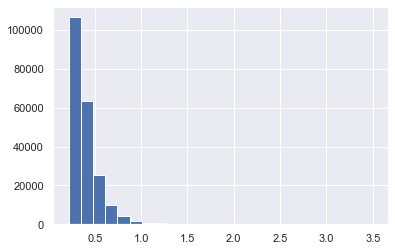

In [107]:
val_data_v2.PredSale_gradBoost.hist(bins = 25)

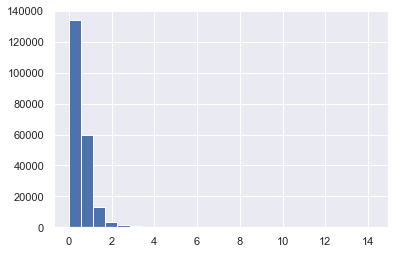

In [108]:
val_data_v2.PredSale_adaBoost.hist(bins = 25)

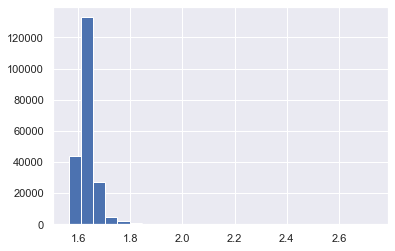

In [109]:
val_data_v2.PredSale.hist(bins = 25)

#### Continue.....

In [129]:
val_data_v2 = pd.read_csv('final_prediction.csv')

In [130]:
val_data_v2.head()

,Date,shop_id,item_id,PredSale_gradBoost,Sale,PredSale_adaBoost,month,ID,date,date_block_num,item_price,item_cnt_day,PredictedVar,PredSale
0,2015-11-01,5,5037,0.510954,0.0,0.615385,11,0,2015-11-01,35,NaN,NaN,1.650795,1.650795
1,2015-11-01,5,5320,0.380959,0.0,0.500000,11,1,2015-11-01,35,NaN,NaN,1.631078,1.631078
2,2015-11-01,5,5233,0.726859,0.0,1.000000,11,2,2015-11-01,35,NaN,NaN,1.676665,1.676665
3,2015-11-01,5,5232,0.442475,0.0,0.764706,11,3,2015-11-01,35,NaN,NaN,1.650795,1.650795
4,2015-11-01,5,5268,0.557181,0.0,1.062500,11,4,2015-11-01,35,NaN,NaN,1.670371,1.670371


In [144]:
val_data_v2.shape

(214200, 14)

In [145]:
final_prediction = val_data_v2[['ID','shop_id','item_id','PredSale_adaBoost']]
final_prediction = final_prediction.rename(columns = {'PredSale_adaBoost': 'item_cnt_month'})
final_prediction['item_cnt_month'] = final_prediction['item_cnt_month'].clip(0,20)

In [146]:
final_prediction.to_csv('miguel_prediction.csv',index = False, header = True)

This result got 1.21 and 1.23

##### probing

In [147]:
dfx = daily_train.groupby(['item_id', 'shop_id']).agg(Found = ('item_cnt_day','max')).reset_index()
dfx['Found'] = True

In [148]:
df_go = final_prediction.merge(dfx, on = ['item_id','shop_id'], how = 'left')
df_go['Found'] = df_go['Found'].fillna(False)

In [149]:
df_go.groupby('Found').agg(count = ('ID','count'))

,count
Found,
False,102796
True,111404


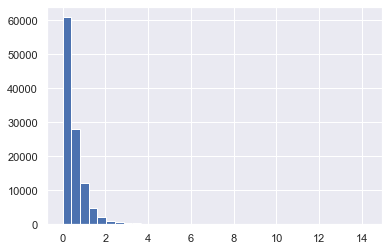

In [150]:
df_go[df_go.Found == True].item_cnt_month.hist(bins = 35)

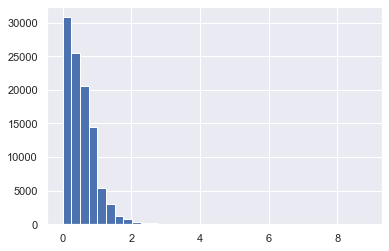

In [151]:
df_go[df_go.Found == False].item_cnt_month.hist(bins = 35)

In [152]:
df_go.sort_values('ID')[['ID','item_cnt_month']].to_csv('miguel_prediction.csv',index = False, header = True)